# Anomaly Detection & Recommender Systems

## 1 Anomaly detection

Throughout this excercise, an anomaly detection algorithm to detect anomalous behavior in server computers is implemented. 
The features measure the throughput in mb/s and latency in ms of response of each server. 
307 examples of how their behaviour were captured and stored in unlabeled dataset ${x^{(1)}, x^{(1)}, ..., x^{(m)}}$.
The 2D plot of throughput vs. latency is plotted using following code:

In [61]:
import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score

In [2]:
dataset = sio.loadmat('ex8data1.mat')
print(dataset['__header__'])
X = dataset['X']

b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 15:37:10 2011'


In [3]:
def plotData(X):
    plt.plot(X[:, 0], X[:, 1],
            linestyle='None', marker='x')
    plt.xlabel('latency (ms)')
    plt.ylabel('throughput (mb/s)')

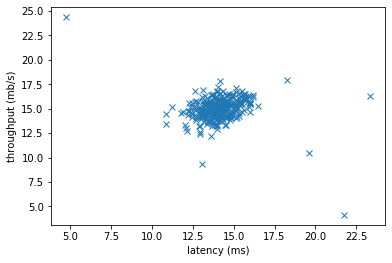

In [4]:
plotData(X)
plt.show()

The vast majority of these examples ar non-anomalous examples of the server operating normally, due to the plotted figure, but there might also be some examples of servers acting anomalously within given dataset.

The Gaussian model is used here in order to detect anomalous examples.

### 1.1 Gaussian distribution

To perform anomaly detection, the model should be fitted to the data's distribution. Given a training set {$x^{(1)}, ...,x^{(m)}$} where $x^{(i)} \in \bf{R}$, the Gaussian distribution for each of the features should be estimated. For each feature $i=1, ..., n$, estimate parameters are mean and variance that fit the data in the $i$-th dimension {$x_{i}^{(1)}, ...,x_{i}^{(m)}$}

The Gaussian distribution is given by:

$$
p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

where $\mu$ is the mean and $\sigma^2$ is the variance.

### 1.2 Estimating parameters for a Gaussian

Estimated parameters $\mu_{i}$ and $\sigma_{i}^2$ of the $i$-th feature are defined using following expressions:
$$
\mu_{i} = \frac{1}{m}\sum_{j=1}^{m}x_{i}^{(j)}
$$

$$
\sigma_{i}^2 = \frac{1}{m}\sum_{j=1}^{m}(x_{i}^{(j)} - \mu_{i})^2
$$

In [5]:
def estimateGaussian(X):
    m, n = X.shape
       
    mu = np.mean(X, axis=0)
    var = 1/m * np.sum(np.square(X - mu), axis=0)
    return mu, var

def estimateMultivariateGaussian(X):
    m, n = X.shape
       
    mu = np.mean(X, axis=0)
    var = ((X - mu).T @ (X - mu)) / m
    return mu, var

def gaussianDistribution(X, mu, var):
    m, n = X.shape
    p = np.zeros((m, 1))
    
    if(np.ndim(var)==1):
        var = np.diag(var) # elements on diagonal on square matrix
   
    norm = 1/((2*np.pi)**(n/2) * np.sqrt(np.linalg.det(var)))
    for i in range(m):
        p[i] = np.exp(-0.5 * ((X[i] - mu).T) @ (np.linalg.inv(var)) @ (X[i] - mu))
    return norm * p

def visualizeFit(X, mu, var):
    X1, X2 = np.meshgrid(np.arange(0,30, step=0.5), np.arange(0,30, step=0.5))
   
    Z = gaussianDistribution(np.concatenate((X1.ravel().reshape(-1,1),
                                             X2.ravel().reshape(-1,1)),
                                             axis=1),
                            mu, var)
    Z = np.reshape(Z, (X1.shape))
    plotData(X)
    plt.contour(X1, X2, Z, levels=[10**exp for exp in range(-20,0,3)])

In [6]:
mu, var = estimateGaussian(X)
p = gaussianDistribution(X, mu, var) # returns probability density

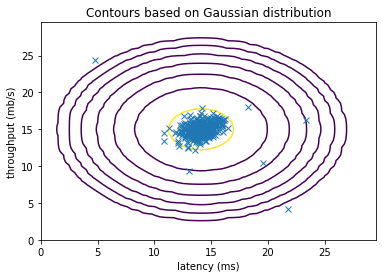

In [7]:
visualizeFit(X, mu, var)
plt.title('Contours based on Gaussian distribution')
plt.show()

In [10]:
mu, var = estimateMultivariateGaussian(X)
p = gaussianDistribution(X, mu, var) # returns probability density

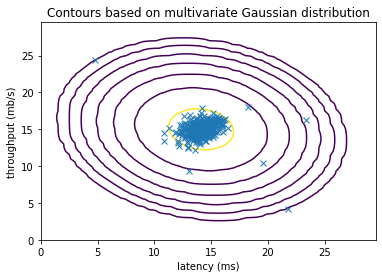

In [11]:
visualizeFit(X, mu, var)
plt.title('Contours based on multivariate Gaussian distribution')
plt.show()

### 1.3 Selecting the threshold, ε

The low probability examples are more likely to be the anomalies in the dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 
Threshold here is selected based on *F1* score on a cross validation set.

In [66]:
def selectThreshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0 
    
    epsilons = iter(np.linspace(np.min(pval), np.max(pval), 1000))
    for epsilon in epsilons:
        predictions = pval < epsilon
        
        tp = np.sum((predictions==True) & (yval == 1))
        fp = np.sum((predictions==True) & (yval==0))
        fn = np.sum((predictions==False) & (yval==1))
        
        if(tp+fp==0 or tp+fn==0): next(epsilons)
        else:
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)

            F1 = 2 * prec * rec / (prec + rec)

            if(F1>bestF1):
                bestF1 = F1
                bestEpsilon = epsilon
    return bestEpsilon, bestF1

def selectThresholdSKlearn(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0 
    
    epsilons = iter(np.linspace(np.min(pval), np.max(pval), 1000))
    for epsilon in epsilons:
        predictions = pval < epsilon
        F1 = f1_score(yval, predictions)
        if(F1>bestF1):
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

In [67]:
Xval = dataset['Xval']
yval = dataset['yval']

mu, var = estimateMultivariateGaussian(X)
pval = gaussianDistribution(X, mu, var)

epsilon, F1 = selectThresholdSKlearn(yval, pval)

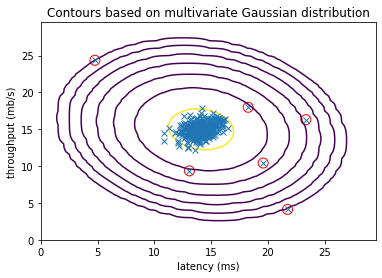

In [68]:
outliers = np.where(p < epsilon)
visualizeFit(X, mu, var)
plt.scatter(X[outliers, 0], X[outliers, 1], edgecolors='r', facecolors='none', s=100)
plt.title('Contours based on multivariate Gaussian distribution')
plt.show()

### 1.4 High dimensional dataset 

Here, the anomaly detection algorithm is implemented on a more realistic and harder dataset. In this dataset, each example is descibed using 11 features, capturing many properties of computer servers. 